#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
# 주어진 데이터 셋을 불러오세요.(3개)
path1 = '/content/drive/MyDrive/AIVLE/Mini_project/AI_미니프로젝트 1차_실습자료/data01_test.csv'
test = pd.read_csv(path1)
path2 = '/content/drive/MyDrive/AIVLE/Mini_project/AI_미니프로젝트 1차_실습자료/data01_train.csv'
train = pd.read_csv(path2)
path3 = '/content/drive/MyDrive/AIVLE/Mini_project/AI_미니프로젝트 1차_실습자료/features.csv'
features = pd.read_csv(path3)

In [6]:
#불필요한 칼럼을 삭제하세요.
test.drop('subject', axis=1, inplace=True)
train.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [7]:
# 전체 데이터의 행, 열 개수를 확인
test.shape

(1471, 562)

In [8]:
train.shape

(5881, 562)

In [9]:
features.shape

(561, 4)

In [10]:
# 전체 데이터의 상위 5개 행 확인
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [11]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [12]:
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [13]:
#전체 데이터의 수치형 변수 분포 확인
test.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


In [14]:
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [15]:
features.describe()

,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,"angle(Z,gravityMean)"
freq,79,126,76,1


In [16]:
#전체 데이터의 모든 변수 확인
test.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [17]:
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [18]:
features.columns

Index(['sensor', 'agg', 'axis', 'feature_name'], dtype='object')

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [19]:
import_data = pd.read_csv('/content/drive/MyDrive/AIVLE/Mini_project/AI_미니프로젝트 1차_실습자료/import_sort_data.csv')
# 1에서 저장한 파일 이름과 통일하면 좋을듯
# df.to_csv(path + 'import_sort_data.csv')
X = train.drop('Activity', axis=1)
x = train[import_data['feature_name'][:210]]
x

,"angle(X,gravityMean)",tGravityAcc-energy()-X,tGravityAcc-min()-Y,"angle(Y,gravityMean)",tGravityAcc-max()-Y,tGravityAcc-mean()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-Y,...,tGravityAcc-std()-Z,fBodyGyro-mean()-Y,tBodyGyro-energy()-Z,"fBodyAccJerk-bandsEnergy()-1,8.2",tBodyAcc-mad()-Y,"fBodyGyro-bandsEnergy()-25,48.2",fBodyBodyGyroMag-meanFreq(),fBodyAcc-max()-Y,fBodyBodyGyroMag-energy(),fBodyGyro-std()-Y
0,-0.601120,0.673768,-0.334921,0.331298,-0.370494,0.875254,0.805627,0.891969,-0.358842,-0.775936,...,-0.970475,-0.974264,-0.999479,-0.999709,-0.962596,-0.999906,-0.248487,-0.963993,-0.999448,-0.965697
1,0.345205,-0.893830,0.937432,-0.769186,0.873312,-0.134711,-0.200892,-0.095343,0.924656,0.714508,...,-0.988593,-0.978759,-0.999887,-0.999932,-0.993870,-0.999960,-0.288496,-0.996704,-0.999576,-0.975541
2,-0.833564,0.906252,-0.145801,0.202434,-0.195671,0.965965,0.891615,0.985606,-0.174095,-0.953043,...,-0.997672,-0.995670,-0.999876,-0.999963,-0.982187,-0.999943,0.375361,-0.991351,-0.999940,-0.996758
3,-0.695819,0.805419,-0.275699,0.287154,-0.309430,0.927343,0.858160,0.943954,-0.297703,-0.849096,...,-0.953040,-0.463715,-0.808021,-0.899938,0.014245,-0.877453,0.136491,-0.231513,-0.849297,-0.417537
4,-0.705029,0.738738,-0.263482,0.264952,-0.236084,0.901125,0.858531,0.901943,-0.260540,-0.885215,...,-0.621825,-0.619732,-0.819772,-0.870319,-0.109680,-0.984466,-0.350359,-0.431145,-0.714778,-0.551035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,-0.912365,0.925506,-0.027374,0.114009,-0.063552,0.973223,0.899036,0.992398,-0.044093,-0.998616,...,-0.922172,-0.978780,-0.999412,-0.999020,-0.932830,-0.999924,-0.279788,-0.928790,-0.999580,-0.966028
5877,-0.690278,0.763412,-0.291398,0.303194,-0.325357,0.910932,0.843681,0.921001,-0.317517,-0.826961,...,-0.972043,-0.453547,-0.923659,-0.916048,-0.109923,-0.963245,-0.373975,-0.521588,-0.679045,0.023878
5878,0.620363,-0.998561,0.700942,-0.437247,0.639925,-0.514220,-0.579367,-0.465011,0.684910,-0.046641,...,-0.995867,-0.991058,-0.999686,-0.999863,-0.988852,-0.999947,0.407531,-0.994378,-0.999931,-0.992607
5879,-0.718009,0.790552,-0.293450,0.292856,-0.314572,0.921553,0.852565,0.932387,-0.302780,-0.843467,...,-0.946076,-0.525871,-0.764451,-0.946701,0.023353,-0.964395,-0.157088,-0.054457,-0.805654,-0.479162


In [20]:
y = train['Activity']
y

,Activity
0,STANDING
1,LAYING
2,STANDING
3,WALKING
4,WALKING_DOWNSTAIRS
...,...
5876,SITTING
5877,WALKING_UPSTAIRS
5878,LAYING
5879,WALKING_UPSTAIRS


### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [21]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [22]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

In [23]:
# 기존 레이블 저장
labels = label_encoder.classes_

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [24]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [25]:
baseline_model = Sequential([
    Dense(6, input_shape=(X_train.shape[1],), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
baseline_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
history_base = baseline_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5456 - loss: 1.2280 - val_accuracy: 0.8768 - val_loss: 0.5339
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8644 - loss: 0.4940 - val_accuracy: 0.9201 - val_loss: 0.3521
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9038 - loss: 0.3550 - val_accuracy: 0.9380 - val_loss: 0.2745
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9283 - loss: 0.2740 - val_accuracy: 0.9439 - val_loss: 0.2309
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9385 - loss: 0.2317 - val_accuracy: 0.9516 - val_loss: 0.2005
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9417 - loss: 0.2079 - val_accuracy: 0.9499 - val_loss: 0.1815
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9491 - loss: 0.1826 - val_accuracy: 0.9558 - val_loss: 0.1675
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9482 - loss: 0.1684 - val_accuracy: 

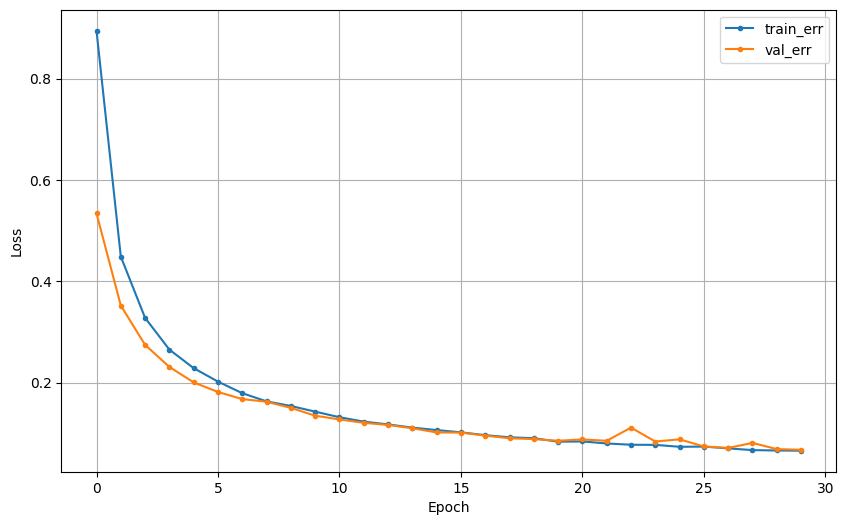

In [27]:
# 학습곡선
dl_history_plot(history_base.history)

In [28]:
from sklearn.metrics import accuracy_score

# 예측 확률 → 클래스 예측
y_pred_proba = baseline_model.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

# 정확도 계산
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9830076465590484


In [29]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [30]:
# 모델 설계
model_5 = Sequential()

# 입력층과 5개 이상의 은닉층
model_5.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # 첫 번째 은닉층
model_5.add(Dropout(0.3))  # 과적합 방지

model_5.add(Dense(128, activation='relu'))  # 두 번째 은닉층
model_5.add(Dropout(0.3))

model_5.add(Dense(128, activation='relu'))  # 세 번째 은닉층
model_5.add(Dropout(0.3))

model_5.add(Dense(128, activation='relu'))  # 네 번째 은닉층
model_5.add(Dropout(0.3))

model_5.add(Dense(128, activation='relu'))  # 다섯 번째 은닉층
model_5.add(Dropout(0.3))

# 출력층 (클래스 수에 맞게 유닛 개수 설정)
model_5.add(Dense(6, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# 컴파일 및 학습
model_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_5 = model_5.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3307 - loss: 1.4567 - val_accuracy: 0.7570 - val_loss: 0.6358
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6654 - loss: 0.7008 - val_accuracy: 0.8734 - val_loss: 0.2891
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8260 - loss: 0.3924 - val_accuracy: 0.9167 - val_loss: 0.2363
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8575 - loss: 0.3528 - val_accuracy: 0.9337 - val_loss: 0.1962
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8817 - loss: 0.3004 - val_accuracy: 0.9465 - val_loss: 0.1539
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8885 - loss: 0.3076 - val_accuracy: 0.9397 - val_loss: 0.1775
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8904 - loss: 0.2900 - val_accuracy: 0.9516 - val_loss: 0.1149
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9209 - loss: 0.2037 - val_accuracy: 0

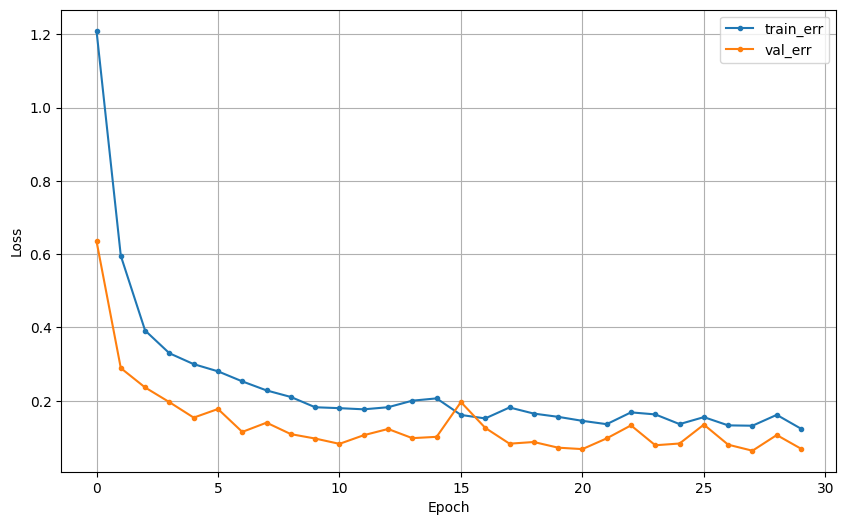

In [32]:
# 학습곡선
dl_history_plot(history_5.history)

In [33]:
from sklearn.metrics import accuracy_score

# 예측 확률 → 클래스 예측
y_pred_proba = model_5.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

# 정확도 계산
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9770603228547153


### (3) 모델3 : 학습률, epoch 등 조정

In [34]:
# 모델 설계
model_v3 = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')  # 다중 클래스 분류 출력층
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# 컴파일 및 학습
model_v3.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',  # 다중 클래스 분류에 적합한 손실 함수
                metrics=['accuracy'])

history_v3 = model_v3.fit(X_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4195 - loss: 1.3292 - val_accuracy: 0.7816 - val_loss: 0.4236
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7861 - loss: 0.4849 - val_accuracy: 0.9006 - val_loss: 0.2571
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8514 - loss: 0.3304 - val_accuracy: 0.9320 - val_loss: 0.1702
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8970 - loss: 0.2401 - val_accuracy: 0.9575 - val_loss: 0.1332
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9148 - loss: 0.2120 - val_accuracy: 0.9507 - val_loss: 0.1435
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9270 - loss: 0.1903 - val_accuracy: 0.9558 - val_loss: 0.1228
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9155 - loss: 0.1990 - val_accuracy: 0.9465 - val_loss: 0.1136
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9446 - loss: 0.1417 - val_accuracy: 0

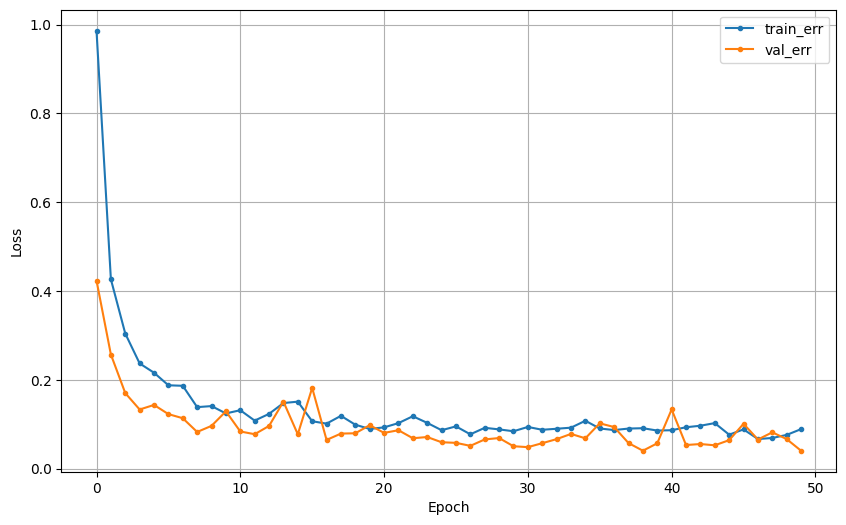

In [36]:
# 학습곡선
dl_history_plot(history_v3.history)

In [37]:
from sklearn.metrics import accuracy_score

# 예측 확률 → 클래스 예측
y_pred_proba = model_v3.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

# 정확도 계산
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.983857264231096


### (4) 모델4 :  학습률, epoch 등 조정

In [38]:
# 모델 설계
model_v4 = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')  # 다중 클래스 분류 출력층
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# 컴파일 및 학습
model_v4.compile(optimizer=Adam(learning_rate=0.0005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history_v4 = model_v4.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3483 - loss: 1.5045 - val_accuracy: 0.8250 - val_loss: 0.6626
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7094 - loss: 0.7106 - val_accuracy: 0.8522 - val_loss: 0.3414
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8209 - loss: 0.4399 - val_accuracy: 0.9269 - val_loss: 0.2182
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8651 - loss: 0.3174 - val_accuracy: 0.9363 - val_loss: 0.1647
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8829 - loss: 0.2675 - val_accuracy: 0.9439 - val_loss: 0.1289
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9056 - loss: 0.2292 - val_accuracy: 0.9533 - val_loss: 0.1256
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9278 - loss: 0.1807 - val_accuracy: 0.9677 - val_loss: 0.0968
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9363 - loss: 0.1598 - val_accu

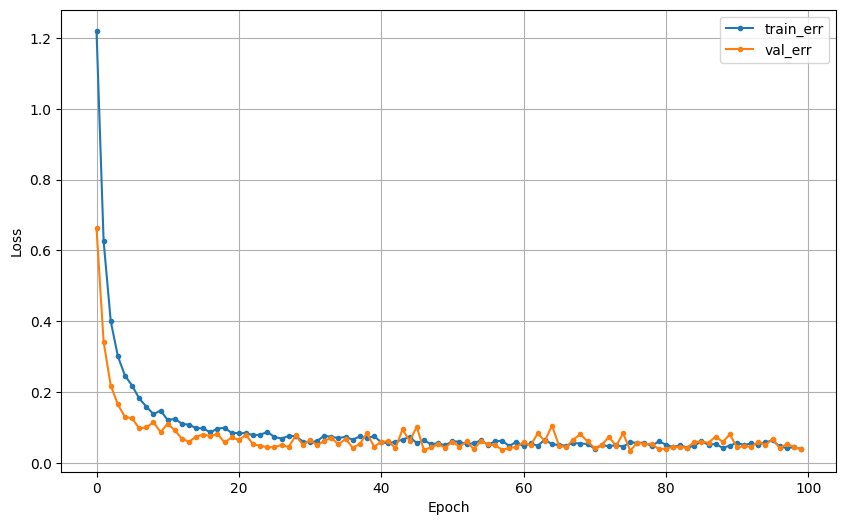

In [40]:
# 학습곡선
dl_history_plot(history_v4.history)

In [41]:
from sklearn.metrics import accuracy_score

# 예측 확률 → 클래스 예측
y_pred_proba = model_v3.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)

# 정확도 계산
acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.983857264231096


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [42]:
#전체 데이터 불러오기(test)
path1 = '/content/drive/MyDrive/AIVLE/Mini_project/AI_미니프로젝트 1차_실습자료/data01_test.csv'
test = pd.read_csv(path1)
path2 = '/content/drive/MyDrive/AIVLE/Mini_project/AI_미니프로젝트 1차_실습자료/data01_train.csv'
train = pd.read_csv(path2)
path3 = '/content/drive/MyDrive/AIVLE/Mini_project/AI_미니프로젝트 1차_실습자료/features.csv'
features = pd.read_csv(path3)

# subject 삭제
test.drop('subject', axis=1, inplace=True)
train.drop('subject', axis=1, inplace=True)

# x, y 분할
X = train.drop('Activity', axis=1)
y = train['Activity']

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# x : 스케일링 적용
scaler = MinMaxScaler()

X_scared = scaler.fit_transform(X)

X_scared_df = pd.DataFrame(X_scared, columns=X.columns)

# y : 정수인코딩 적용
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

# 기존 레이블 저장
labels = label_encoder.classes_

In [43]:
# test 데이터에 대한 성능 측정
import pandas as pd

# 결과 저장할 리스트
results = []

# baseline_model 결과 저장
acc_baseline = accuracy_score(y_val, np.argmax(baseline_model.predict(X_val), axis=1))
results.append(["Baseline Model", acc_baseline])

# model_5 결과 저장
acc_baseline = accuracy_score(y_val, np.argmax(model_5.predict(X_val), axis=1))
results.append(["Model_5", acc_baseline])

# model_v3 결과 저장
acc_v3 = accuracy_score(y_val, np.argmax(model_v3.predict(X_val), axis=1))
results.append(["Model v3", acc_v3])

# model_v4 결과 저장
acc_v4 = accuracy_score(y_val, np.argmax(model_v4.predict(X_val), axis=1))
results.append(["Model v4", acc_v4])

# 데이터프레임으로 정리
results_df = pd.DataFrame(results, columns=["Model", "Test Accuracy"])

# 출력
print(results_df)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
            Model  Test Accuracy
0  Baseline Model       0.983008
1         Model_5       0.977060
2        Model v3       0.983857
3        Model v4       0.988955


#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.